In [52]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword
import numpy as np
import matplotlib.pyplot as plt

In [53]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 51, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.ny, 1, well_index=10)
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, 1, 1, well_index=10)
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, self.ny, 1, well_index=10)
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, 1, 1, well_index=10)
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 200
        self.params.tolerance_newton = 1e-1
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
  
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

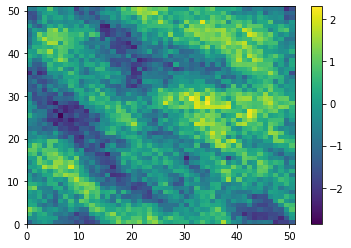

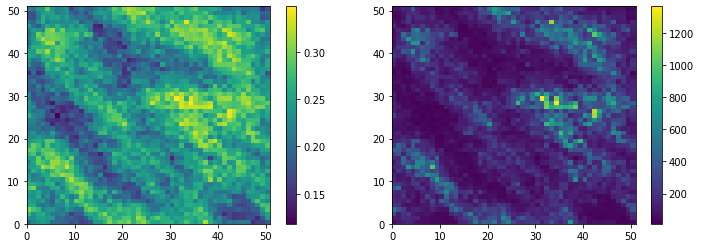

In [54]:
from scipy.io import loadmat
data = loadmat('model_50.mat')
realiz = np.array(data['realz'])

plt.figure(num=None)
plt.pcolor(realiz)
plt.colorbar()

mean = 0.24
stdev = 0.04
mean_v = np.mean(realiz)
stdev_v = np.std(realiz)

phi_v = mean - mean_v*(stdev/stdev_v) + realiz*(stdev/stdev_v)
K_v = 10**(9*phi_v)

plt.figure( figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi_v)
plt.colorbar()

plt.subplot(122)
plt.pcolor(K_v)
plt.colorbar()

Building connection list...
# 1 	T =   1	DT =  1	NI = 1	LI=4
# 2 	T =   3	DT =  2	NI = 2	LI=9
# 3 	T =   7	DT =  4	NI = 4	LI=18
# 4 	T =  15	DT =  8	NI = 1	LI=5
# 5 	T =  31	DT = 16	NI = 1	LI=5
# 6 	T =  63	DT = 32	NI = 2	LI=11
# 7 	T = 127	DT = 64	NI = 2	LI=12
# 8 	T = 255	DT = 128	NI = 2	LI=14
# 9 	T = 455	DT = 200	NI = 4	LI=22
# 10 	T = 655	DT = 200	NI = 3	LI=19
# 11 	T = 855	DT = 200	NI = 2	LI=15
# 12 	T = 1055	DT = 200	NI = 1	LI=7
# 13 	T = 1255	DT = 200	NI = 4	LI=23
# 14 	T = 1455	DT = 200	NI = 5	LI=31
# 15 	T = 1655	DT = 200	NI = 3	LI=21
# 16 	T = 1855	DT = 200	NI = 3	LI=21
# 17 	T = 2055	DT = 200	NI = 3	LI=19
# 18 	T = 2255	DT = 200	NI = 3	LI=20
# 19 	T = 2455	DT = 200	NI = 3	LI=20
# 20 	T = 2655	DT = 200	NI = 3	LI=18
# 21 	T = 2855	DT = 200	NI = 3	LI=19
# 22 	T = 3055	DT = 200	NI = 3	LI=20
# 23 	T = 3255	DT = 200	NI = 3	LI=19
# 24 	T = 3455	DT = 200	NI = 3	LI=20
# 25 	T = 3655	DT = 200	NI = 2	LI=14
# 26 	T = 3855	DT = 200	NI = 2	LI=14
# 27 	T = 4000	DT = 145	NI = 2	LI=12
TS = 

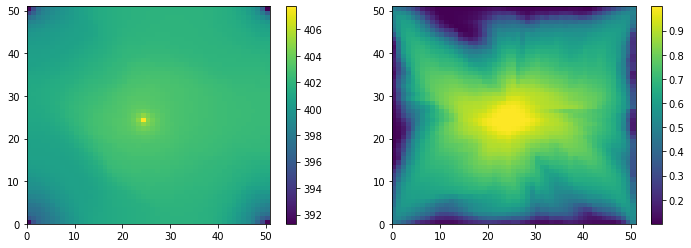

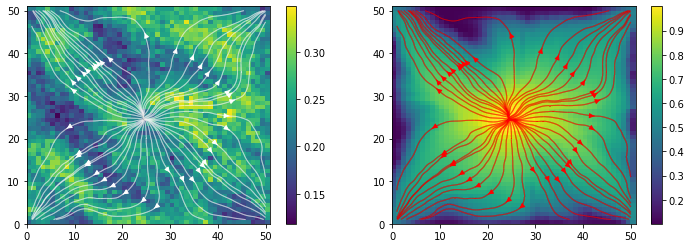

In [55]:
nb = 51
m = Model(K_v, nb)
m.ix = np.int(m.nx / 2)
m.iy = np.int(m.ny / 2)
m.reservoir.add_well("INJ1")
m.reservoir.add_perforation(m.reservoir.wells[-1], m.ix, m.iy, 1,  well_index=10)

m.init()
m.run_python(4000)
m.print_timers()

# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0:2*nb:2]
z = X[1:2*nb:2]
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()

plt.figure(figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p, phi_v, 'w')
plt.colorbar()

plt.subplot(122)
m.plot_streamline(p, z)
plt.colorbar()

Building connection list...
# 1 	T =   1	DT =  1	NI = 1	LI=4
# 2 	T =   3	DT =  2	NI = 2	LI=9
TS = 2(0), NI = 3(0), LI = 13(0)
Total elapsed 0.130000 sec
	initialization 0.013000 sec
		connection list generation 0.008000 sec
	simulation 0.100000 sec
		jacobian assembly 0.042000 sec
			interpolation 0.040000 sec
				acc flux interpolation 0.044000 sec
					body generation 0.043000 sec
						point generation 0.043000 sec
				rate interpolation 0.000000 sec
					body generation 0.000000 sec
						point generation 0.003000 sec
		linear solver setup 0.023000 sec
			GMRES 0.023000 sec
				CPR 0.023000 sec
					AMG 0.019000 sec
					ILU(0) 0.004000 sec
		linear solver solve 0.025000 sec
			GMRES 0.025000 sec
				CPR 0.021000 sec
					AMG 0.012000 sec
					ILU(0) 0.008000 sec
		newton update 0.006000 sec
			composition correction 0.003000 sec



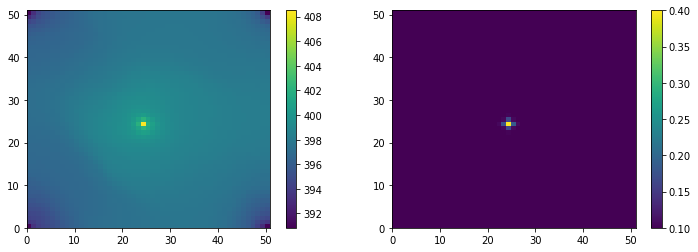

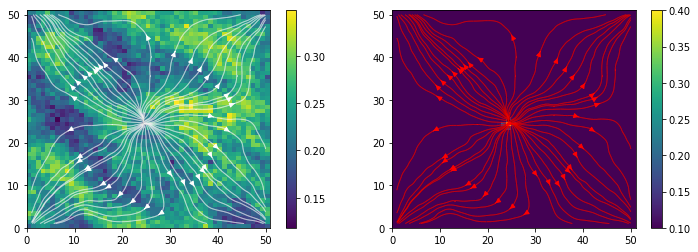

In [56]:
# Model with less time-steps
m = Model(K_v)
m.ix = np.int(m.nx / 2)
m.iy = np.int(m.ny / 2)
m.reservoir.add_well("INJ1")
m.reservoir.add_perforation(m.reservoir.wells[-1], m.ix, m.iy, 1,  well_index=10)

m.init()
m.run_python(3)
m.print_timers()

# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0:2*nb:2]
z = X[1:2*nb:2]

# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()


plt.figure(figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p, phi_v, 'w')
plt.colorbar()

plt.subplot(122)
m.plot_streamline(p, z)
plt.colorbar()

At a lower total time we see more spreadout streamlines which is due to the fact that pressure perturbation from cell to cell is negligible. As we can see above, some of the streamlines are not close to the producer which suggests the pressure difference between the producer and that position where streamline ends is so low that velocity is computed as zero. <br>

Where as at the time of breakthrough there is a notable difference in pressure generated between injectors and producers which gives us larger value for velocity field in that area near the producers.


Building connection list...
# 1 	T =   1	DT =  1	NI = 3	LI=12
# 2 	T =   3	DT =  2	NI = 1	LI=4
# 3 	T =   7	DT =  4	NI = 1	LI=4
# 4 	T =  15	DT =  8	NI = 1	LI=5
# 5 	T =  31	DT = 16	NI = 1	LI=5
# 6 	T =  63	DT = 32	NI = 1	LI=6
# 7 	T = 127	DT = 64	NI = 3	LI=19
# 8 	T = 255	DT = 128	NI = 7	LI=38
# 9 	T = 455	DT = 200	NI = 5	LI=31
# 10 	T = 655	DT = 200	NI = 4	LI=24
# 11 	T = 855	DT = 200	NI = 3	LI=18
# 12 	T = 1055	DT = 200	NI = 3	LI=17
# 13 	T = 1255	DT = 200	NI = 3	LI=16
# 14 	T = 1455	DT = 200	NI = 2	LI=13
# 15 	T = 1655	DT = 200	NI = 3	LI=18
# 16 	T = 1855	DT = 200	NI = 2	LI=13
# 17 	T = 2055	DT = 200	NI = 2	LI=14
# 18 	T = 2255	DT = 200	NI = 3	LI=21
# 19 	T = 2455	DT = 200	NI = 2	LI=15
# 20 	T = 2655	DT = 200	NI = 3	LI=23
# 21 	T = 2855	DT = 200	NI = 3	LI=23
# 22 	T = 3055	DT = 200	NI = 3	LI=22
# 23 	T = 3255	DT = 200	NI = 3	LI=22
# 24 	T = 3455	DT = 200	NI = 3	LI=20
# 25 	T = 3655	DT = 200	NI = 3	LI=21
# 26 	T = 3855	DT = 200	NI = 2	LI=15
# 27 	T = 4000	DT = 145	NI = 3	LI=20
TS = 

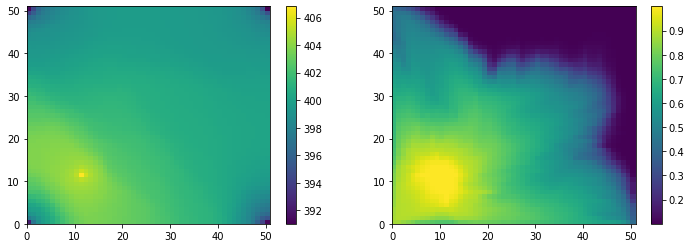

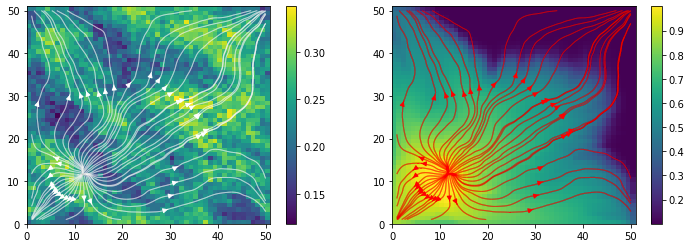

In [57]:
m = Model(K_v)
m.ix = np.int(m.nx / 4)
m.iy = np.int(m.ny / 4)
m.reservoir.add_well("INJ1")
m.reservoir.add_perforation(m.reservoir.wells[-1], m.ix, m.iy, 1,  well_index=10)

m.init()

m.run_python(4000)
m.print_timers()

# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0:2*nb:2]
z = X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()


plt.figure(figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p, phi_v, 'w')
plt.colorbar()

plt.subplot(122)
m.plot_streamline(p, z)
plt.colorbar()

In this case we can specify different pressure control for different producers such that saturation front moves towards all the producer wells uniformly